In [1]:
#!/usr/bin/python3.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
# import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# ================= CONSTANTS =================
PMT_PULSE_LENGTH = 1500  # Sample lenght of a typical pulse

# Loading dataset

In [26]:
#No normalization is required
#Loading isolated pulses (not long traces)
df = pd.read_csv("../PeakDetection_MultiSources_IndividualPulses2kV.csv", index_col = 0)
df2 = pd.read_csv("../PeakDetection_MultiSources_IndividualPulses2kVv2.csv", index_col = 0)
df = pd.concat([df.T, df2.T], ignore_index = True)
# df = df2.T

In [27]:
df

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0        56    67    68    81    90    68    52    46    42    52  ...   136   
1       134   135   135   136   137   136   136   136   137   136  ...   133   
2       131   132   132   134   135   131   129   128   118   105  ...   136   
3       137   136   136   136   138   136   136   137   136   136  ...   136   
4        92    96    99   104   113   113    97    84    86    86  ...   137   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
46615    27    34    50    63    70    62    62    57    47    57  ...   137   
46616   136   136   136   135   138   136   136   135   137   136  ...   136   
46617   135   136   136   136   137   136   136   135   136   136  ...   136   
46618   137   136   136   135   138   136   137   136   137   136  ...   136   
46619     5    50    60    88    97    74    69    85    89    86  ...   136   

       1491  1492  1493  1494  1495  1496  1497  1498  1499  
0       136   136   136   137   136   136   135   136   136  
1       134   135   135   135   134   136   136   135   125  
2       135   136   136   136   135   136   136   136   136  
3       135   137   136   137   136   137   136   136   136  
4       136   136   136   137   136   137   136   136   136  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
46615   136   137   136   136   136   137   136   136   136  
46616   136   136   136   137   136   136   136   136   136  
46617   136   136   136   136   136   137   136   137   136  
46618   137   136   136   136   136   136   136   137   136  
46619   136   135   136   136   137   136   137   135   136  

[46620 rows x 1500 columns]

# Peak detection and valid pulse filtering algorithms

In [28]:
def pkdetect(x, thr=100, pkh=10):
    peak=[]
    lmax=0
    imax=0
    count=0
    for i in range(1,len(x)):
        if x[i] <= thr:
            pass
        elif x[i] > lmax:
            imax=i
            lmax=x[i]
        elif ((lmax-x[i-1]) > pkh) and (x[i]-x[i-1])>0:
            peak.append(imax)
            lmax=0
        else:
            pass
            
    return peak

In [29]:
def validPulse(x, initThrs = 5, lookForPeakWindow = 10, windowSize = 200, thrshldRatios = 1.25):

    #Check if a high peak pulse is detected at the beginning
    
    partValid = 0
    for i in range(lookForPeakWindow):
        if x[i] > initThrs:
            partValid = 1
#             print("Valid initial peak")
            
    #Is this a decreasing "typical" pulse?
    if partValid:
        initAvg = sum(x[windowSize:]) / windowSize
        endAvg = sum(x[:windowSize]) / windowSize
#         print("Average ratios: " + str(initAvg / endAvg))
        if (initAvg / endAvg) > thrshldRatios:
            return 1
        
    return 0

        

# Filtering only valid typical pulses

### Remove baseline frist

In [30]:
df2 = pd.DataFrame()

In [31]:
for i in range(len(df.T)):
    df2[i] = df.max(axis = 1)[i] - df[i]
df2

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0        81    70    69    57    48    70    85    91    96    86  ...     2   
1         3     2     2     2     1     2     1     1     1     2  ...     5   
2         6     5     5     4     3     7     8     9    20    33  ...     2   
3         0     1     1     2     0     2     1     0     2     2  ...     2   
4        45    41    38    34    25    25    40    53    52    52  ...     1   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
46615   110   103    87    75    68    76    75    80    91    81  ...     1   
46616     1     1     1     3     0     2     1     2     1     2  ...     2   
46617     2     1     1     2     1     2     1     2     2     2  ...     2   
46618     0     1     1     3     0     2     0     1     1     2  ...     2   
46619   132    87    77    50    41    64    68    52    49    52  ...     2   

       1491  1492  1493  1494  1495  1496  1497  1498  1499  
0         2     1     2     1     1     2     3     2     2  
1         4     2     3     3     3     2     2     3    13  
2         3     1     2     2     2     2     2     2     2  
3         3     0     2     1     1     1     2     2     2  
4         2     1     2     1     1     1     2     2     2  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
46615     2     0     2     2     1     1     2     2     2  
46616     2     1     2     1     1     2     2     2     2  
46617     2     1     2     2     1     1     2     1     2  
46618     1     1     2     2     1     2     2     1     2  
46619     2     2     2     2     0     2     1     3     2  

[46620 rows x 1500 columns]

### Apply pulse validation algorithm

In [32]:
df2["ValidPulse"] = df2.apply(validPulse, axis = 1)
df2

0    1   2   3   4   5   6   7   8   9  ...  1491  1492  1493  1494  \
0       81   70  69  57  48  70  85  91  96  86  ...     2     1     2     1   
1        3    2   2   2   1   2   1   1   1   2  ...     4     2     3     3   
2        6    5   5   4   3   7   8   9  20  33  ...     3     1     2     2   
3        0    1   1   2   0   2   1   0   2   2  ...     3     0     2     1   
4       45   41  38  34  25  25  40  53  52  52  ...     2     1     2     1   
...    ...  ...  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
46615  110  103  87  75  68  76  75  80  91  81  ...     2     0     2     2   
46616    1    1   1   3   0   2   1   2   1   2  ...     2     1     2     1   
46617    2    1   1   2   1   2   1   2   2   2  ...     2     1     2     2   
46618    0    1   1   3   0   2   0   1   1   2  ...     1     1     2     2   
46619  132   87  77  50  41  64  68  52  49  52  ...     2     2     2     2   

       1495  1496  1497  1498  1499  ValidPulse  
0         1     2     3     2     2           1  
1         3     2     2     3    13           0  
2         2     2     2     2     2           1  
3         1     1     2     2     2           0  
4         1     1     2     2     2           0  
...     ...   ...   ...   ...   ...         ...  
46615     1     1     2     2     2           0  
46616     1     2     2     2     2           0  
46617     1     1     2     1     2           0  
46618     1     2     2     1     2           0  
46619     0     2     1     3     2           1  

[46620 rows x 1501 columns]

In [33]:
dfPulses = df2.loc[df2["ValidPulse"] > 0]
dfPulses = dfPulses.drop("ValidPulse", axis = 1)
dfPulses

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0        81    70    69    57    48    70    85    91    96    86  ...     2   
2         6     5     5     4     3     7     8     9    20    33  ...     2   
9         2     7    13    13    10    19    23    15    14    11  ...     2   
16        1     2     1     2     1     2     1     2    12    27  ...     2   
44       68    57    52    41    34    46    54    52    50    50  ...    11   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
46600    87    56    50    44    38    50    68    66    73   101  ...    10   
46601    10     7     7     4     3     5     9    10    11     9  ...     2   
46604     9     6     6     5     4     4    11    18    21    13  ...     2   
46610     2     2     2     3     2     4    11    15    17    24  ...     1   
46619   132    87    77    50    41    64    68    52    49    52  ...     2   

       1491  1492  1493  1494  1495  1496  1497  1498  1499  
0         2     1     2     1     1     2     3     2     2  
2         3     1     2     2     2     2     2     2     2  
9         1     1     1     2     1     2     2     2     1  
16        2     1     2     2     1     2     1     2     2  
44       11     8     7     6     3     3     3     3     2  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
46600    11    12    13     9     8     7    12    25    33  
46601     2     1     2     2     1     2     1     2     2  
46604     2     1     2     2     0     2     1     2     1  
46610     1     1     1     2     0     2     1     2     2  
46619     2     2     2     2     0     2     1     3     2  

[9086 rows x 1500 columns]

# ===== DEBUGGING TEST - DO NOT RUN =======

<IPython.core.display.Javascript object>


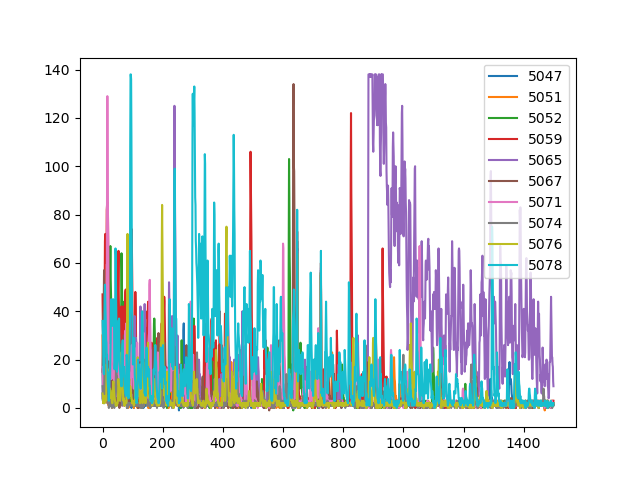

In [34]:
%matplotlib notebook
dfPulses.iloc[1000:1010,:].T.plot()
plt.show()

In [35]:
import random
randPulse = random.randrange(1000)
randPulse

674

<IPython.core.display.Javascript object>


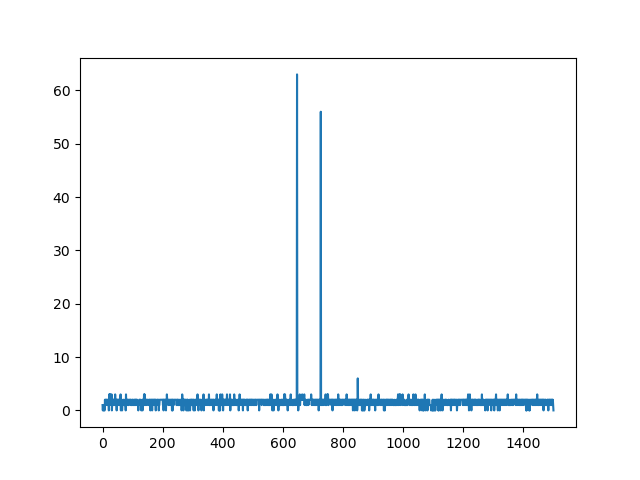

Valid: 0


In [36]:
%matplotlib notebook
sample = df2.iloc[randPulse,:]
sample.plot()
plt.show()
print("Valid: "+ str(validPulse(sample, 5, 10, 200, 1.25)))

# ===== DEBUGGING ENDS HERE :) =======

# Peaks sequence detection

In [37]:
import random
randPulse = random.randrange(len(dfPulses))
randPulse

1773

In [38]:
# Peak time distribution
samplePulse = dfPulses.iloc[randPulse]
samplePulse = samplePulse[:800]
samplePulse["peakLocations"] = pkdetect(samplePulse, 2, 5)
# samplePulse

<IPython.core.display.Javascript object>


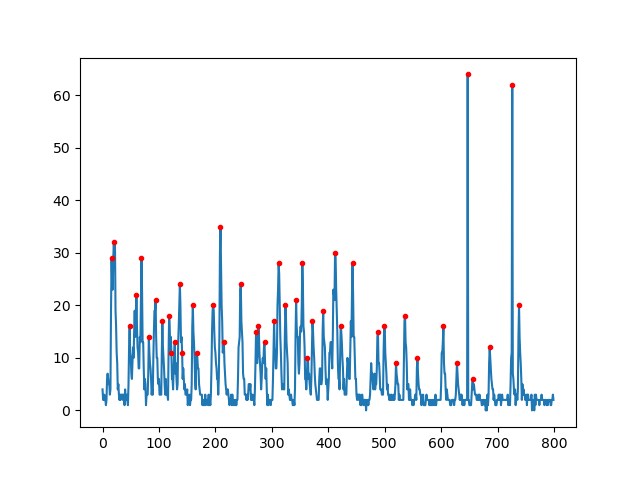

In [39]:
%matplotlib notebook
onlyPulse = samplePulse.iloc[:-1]
peaks = samplePulse.iloc[-1]
ax = onlyPulse.plot()
plt.plot(peaks, onlyPulse[peaks], 'r.')
plt.show()

In [40]:
a = dfPulses.iloc[:100].copy()
a["peakLocations"] = a.apply(pkdetect, args = (5, 5), axis = 1)
b = a.loc[a["peakLocations"].map(len) > 1]
#b[b.columns[:15]]
c = b.loc[:,"peakLocations"]
c

0      [1, 8, 15, 23, 28, 41, 47, 59, 70, 78, 86, 103...
2      [9, 20, 26, 37, 47, 57, 74, 78, 84, 88, 99, 10...
9                              [6, 12, 26, 73, 119, 647]
16     [10, 17, 30, 38, 47, 58, 66, 70, 76, 82, 91, 1...
44     [1, 12, 16, 22, 36, 42, 49, 59, 67, 72, 76, 79...
                             ...                        
505    [1, 8, 14, 28, 39, 43, 54, 61, 80, 87, 93, 97,...
512    [6, 19, 48, 59, 67, 73, 86, 100, 117, 124, 130...
519    [9, 30, 38, 92, 104, 114, 120, 130, 243, 300, ...
526    [8, 14, 20, 25, 43, 49, 55, 71, 106, 115, 134,...
540    [8, 20, 91, 95, 104, 116, 121, 131, 140, 143, ...
Name: peakLocations, Length: 99, dtype: object

In [41]:
#Add peak locations column to each pulse
dfPulses["peakLocations"] = dfPulses[dfPulses.columns[:PMT_PULSE_LENGTH]].apply(pkdetect, args = (2, 5), axis = 1)


#Remove pulses with less than 2 peaks
dfPulses = dfPulses.drop(dfPulses.loc[dfPulses["peakLocations"].map(len) < 2].T, axis = 0)
dfPulses

0   1   2   3   4   5   6   7   8    9  ...  1491  1492  1493  1494  \
0       81  70  69  57  48  70  85  91  96   86  ...     2     1     2     1   
2        6   5   5   4   3   7   8   9  20   33  ...     3     1     2     2   
9        2   7  13  13  10  19  23  15  14   11  ...     1     1     1     2   
16       1   2   1   2   1   2   1   2  12   27  ...     2     1     2     2   
44      68  57  52  41  34  46  54  52  50   50  ...    11     8     7     6   
...    ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
46600   87  56  50  44  38  50  68  66  73  101  ...    11    12    13     9   
46601   10   7   7   4   3   5   9  10  11    9  ...     2     1     2     2   
46604    9   6   6   5   4   4  11  18  21   13  ...     2     1     2     2   
46610    2   2   2   3   2   4  11  15  17   24  ...     1     1     1     2   
46619  132  87  77  50  41  64  68  52  49   52  ...     2     2     2     2   

       1495  1496  1497  1498  1499  \
0         1     2     3     2     2   
2         2     2     2     2     2   
9         1     2     2     2     1   
16        1     2     1     2     2   
44        3     3     3     3     2   
...     ...   ...   ...   ...   ...   
46600     8     7    12    25    33   
46601     1     2     1     2     2   
46604     0     2     1     2     1   
46610     0     2     1     2     2   
46619     0     2     1     3     2   

                                           peakLocations  
0      [1, 8, 15, 23, 28, 41, 47, 59, 70, 78, 86, 103...  
2      [9, 20, 26, 37, 47, 57, 74, 78, 84, 88, 99, 10...  
9           [6, 12, 26, 54, 73, 119, 140, 265, 647, 726]  
16     [10, 17, 30, 38, 47, 58, 66, 70, 76, 82, 91, 1...  
44     [1, 12, 16, 22, 36, 42, 49, 59, 67, 72, 76, 79...  
...                                                  ...  
46600  [1, 10, 16, 33, 44, 61, 64, 68, 71, 87, 94, 10...  
46601  [8, 17, 30, 43, 47, 62, 68, 84, 97, 112, 125, ...  
46604  [8, 451, 469, 482, 499, 511, 524, 534, 542, 57...  
46610  [10, 20, 38, 48, 53, 86, 106, 119, 162, 174, 1...  
46619  [1, 6, 10, 16, 33, 42, 48, 53, 59, 68, 82, 86,...  

[9086 rows x 1501 columns]

### Time between first and Nth peaks

In [42]:
def relativeArrivalTimes(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[0]) #Relative time respect to first peak
    
    return deltaList

### Time between successive peaks

In [43]:
def timeBetweenPeaks(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[i]) #Relative time respect to first peak
    
    return deltaList

In [44]:
dfPulses["arrivalTimes"] = dfPulses["peakLocations"].apply(relativeArrivalTimes)
dfPulses

0   1   2   3   4   5   6   7   8    9  ...  1492  1493  1494  1495  \
0       81  70  69  57  48  70  85  91  96   86  ...     1     2     1     1   
2        6   5   5   4   3   7   8   9  20   33  ...     1     2     2     2   
9        2   7  13  13  10  19  23  15  14   11  ...     1     1     2     1   
16       1   2   1   2   1   2   1   2  12   27  ...     1     2     2     1   
44      68  57  52  41  34  46  54  52  50   50  ...     8     7     6     3   
...    ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
46600   87  56  50  44  38  50  68  66  73  101  ...    12    13     9     8   
46601   10   7   7   4   3   5   9  10  11    9  ...     1     2     2     1   
46604    9   6   6   5   4   4  11  18  21   13  ...     1     2     2     0   
46610    2   2   2   3   2   4  11  15  17   24  ...     1     1     2     0   
46619  132  87  77  50  41  64  68  52  49   52  ...     2     2     2     0   

       1496  1497  1498  1499  \
0         2     3     2     2   
2         2     2     2     2   
9         2     2     2     1   
16        2     1     2     2   
44        3     3     3     2   
...     ...   ...   ...   ...   
46600     7    12    25    33   
46601     2     1     2     2   
46604     2     1     2     1   
46610     2     1     2     2   
46619     2     1     3     2   

                                           peakLocations  \
0      [1, 8, 15, 23, 28, 41, 47, 59, 70, 78, 86, 103...   
2      [9, 20, 26, 37, 47, 57, 74, 78, 84, 88, 99, 10...   
9           [6, 12, 26, 54, 73, 119, 140, 265, 647, 726]   
16     [10, 17, 30, 38, 47, 58, 66, 70, 76, 82, 91, 1...   
44     [1, 12, 16, 22, 36, 42, 49, 59, 67, 72, 76, 79...   
...                                                  ...   
46600  [1, 10, 16, 33, 44, 61, 64, 68, 71, 87, 94, 10...   
46601  [8, 17, 30, 43, 47, 62, 68, 84, 97, 112, 125, ...   
46604  [8, 451, 469, 482, 499, 511, 524, 534, 542, 57...   
46610  [10, 20, 38, 48, 53, 86, 106, 119, 162, 174, 1...   
46619  [1, 6, 10, 16, 33, 42, 48, 53, 59, 68, 82, 86,...   

                                            arrivalTimes  
0      [7, 14, 22, 27, 40, 46, 58, 69, 77, 85, 102, 1...  
2      [11, 17, 28, 38, 48, 65, 69, 75, 79, 90, 100, ...  
9               [6, 20, 48, 67, 113, 134, 259, 641, 720]  
16     [7, 20, 28, 37, 48, 56, 60, 66, 72, 81, 91, 96...  
44     [11, 15, 21, 35, 41, 48, 58, 66, 71, 75, 78, 8...  
...                                                  ...  
46600  [9, 15, 32, 43, 60, 63, 67, 70, 86, 93, 102, 1...  
46601  [9, 22, 35, 39, 54, 60, 76, 89, 104, 117, 123,...  
46604  [443, 461, 474, 491, 503, 516, 526, 534, 571, ...  
46610  [10, 28, 38, 43, 76, 96, 109, 152, 164, 175, 1...  
46619  [5, 9, 15, 32, 41, 47, 52, 58, 67, 81, 85, 91,...  

[9086 rows x 1502 columns]

In [45]:
dfPulses["timeBetweenPeaks"] = dfPulses["peakLocations"].apply(timeBetweenPeaks)
dfPulses

0   1   2   3   4   5   6   7   8    9  ...  1493  1494  1495  1496  \
0       81  70  69  57  48  70  85  91  96   86  ...     2     1     1     2   
2        6   5   5   4   3   7   8   9  20   33  ...     2     2     2     2   
9        2   7  13  13  10  19  23  15  14   11  ...     1     2     1     2   
16       1   2   1   2   1   2   1   2  12   27  ...     2     2     1     2   
44      68  57  52  41  34  46  54  52  50   50  ...     7     6     3     3   
...    ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
46600   87  56  50  44  38  50  68  66  73  101  ...    13     9     8     7   
46601   10   7   7   4   3   5   9  10  11    9  ...     2     2     1     2   
46604    9   6   6   5   4   4  11  18  21   13  ...     2     2     0     2   
46610    2   2   2   3   2   4  11  15  17   24  ...     1     2     0     2   
46619  132  87  77  50  41  64  68  52  49   52  ...     2     2     0     2   

       1497  1498  1499                                      peakLocations  \
0         3     2     2  [1, 8, 15, 23, 28, 41, 47, 59, 70, 78, 86, 103...   
2         2     2     2  [9, 20, 26, 37, 47, 57, 74, 78, 84, 88, 99, 10...   
9         2     2     1       [6, 12, 26, 54, 73, 119, 140, 265, 647, 726]   
16        1     2     2  [10, 17, 30, 38, 47, 58, 66, 70, 76, 82, 91, 1...   
44        3     3     2  [1, 12, 16, 22, 36, 42, 49, 59, 67, 72, 76, 79...   
...     ...   ...   ...                                                ...   
46600    12    25    33  [1, 10, 16, 33, 44, 61, 64, 68, 71, 87, 94, 10...   
46601     1     2     2  [8, 17, 30, 43, 47, 62, 68, 84, 97, 112, 125, ...   
46604     1     2     1  [8, 451, 469, 482, 499, 511, 524, 534, 542, 57...   
46610     1     2     2  [10, 20, 38, 48, 53, 86, 106, 119, 162, 174, 1...   
46619     1     3     2  [1, 6, 10, 16, 33, 42, 48, 53, 59, 68, 82, 86,...   

                                            arrivalTimes  \
0      [7, 14, 22, 27, 40, 46, 58, 69, 77, 85, 102, 1...   
2      [11, 17, 28, 38, 48, 65, 69, 75, 79, 90, 100, ...   
9               [6, 20, 48, 67, 113, 134, 259, 641, 720]   
16     [7, 20, 28, 37, 48, 56, 60, 66, 72, 81, 91, 96...   
44     [11, 15, 21, 35, 41, 48, 58, 66, 71, 75, 78, 8...   
...                                                  ...   
46600  [9, 15, 32, 43, 60, 63, 67, 70, 86, 93, 102, 1...   
46601  [9, 22, 35, 39, 54, 60, 76, 89, 104, 117, 123,...   
46604  [443, 461, 474, 491, 503, 516, 526, 534, 571, ...   
46610  [10, 28, 38, 43, 76, 96, 109, 152, 164, 175, 1...   
46619  [5, 9, 15, 32, 41, 47, 52, 58, 67, 81, 85, 91,...   

                                        timeBetweenPeaks  
0      [7, 7, 8, 5, 13, 6, 12, 11, 8, 8, 17, 13, 12, ...  
2      [11, 6, 11, 10, 10, 17, 4, 6, 4, 11, 10, 10, 1...  
9                  [6, 14, 28, 19, 46, 21, 125, 382, 79]  
16     [7, 13, 8, 9, 11, 8, 4, 6, 6, 9, 10, 5, 18, 18...  
44     [11, 4, 6, 14, 6, 7, 10, 8, 5, 4, 3, 6, 8, 6, ...  
...                                                  ...  
46600  [9, 6, 17, 11, 17, 3, 4, 3, 16, 7, 9, 7, 6, 11...  
46601  [9, 13, 13, 4, 15, 6, 16, 13, 15, 13, 6, 7, 8,...  
46604  [443, 18, 13, 17, 12, 13, 10, 8, 37, 17, 51, 3...  
46610  [10, 18, 10, 5, 33, 20, 13, 43, 12, 11, 12, 15...  
46619  [5, 4, 6, 17, 9, 6, 5, 6, 9, 14, 4, 6, 9, 5, 9...  

[9086 rows x 1503 columns]

## Relative time between first and Nth peak

<IPython.core.display.Javascript object>


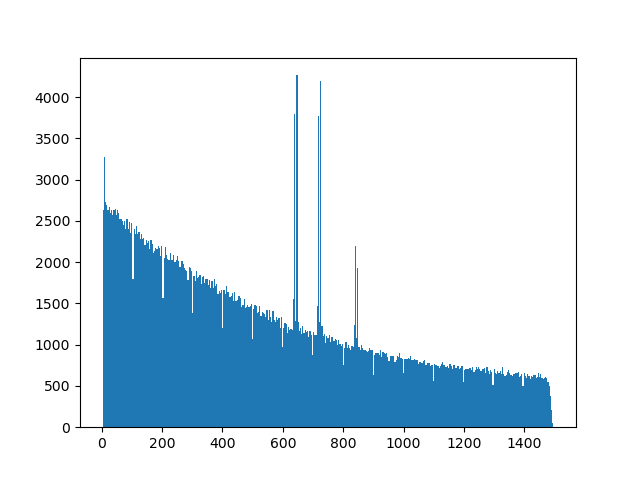

In [46]:
%matplotlib notebook
arrivalTimes = []
for i in dfPulses["arrivalTimes"]:
    arrivalTimes.extend(i)

nBinsFit = int(2*(len(arrivalTimes)**(2/5.0)))
# nBinsFit = 49
    
histData = plt.hist(arrivalTimes, bins = nBinsFit)
plt.show()

In [48]:
nBinsFit

377

# Model fitting
## Finding parameters of exponential distribution for relative times from first peak

In [49]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [50]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [51]:
fittingBoundsAmp = (1000, 10000)
fittingBoundsLam = (1e-6, 1.00)

In [52]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [53]:
distAmp

2643.28496255787

In [54]:
distLambda

0.0010993281984463799

<IPython.core.display.Javascript object>


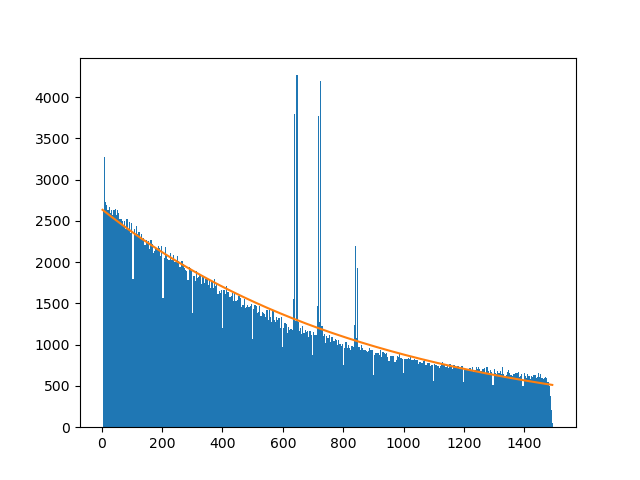

In [55]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(arrivalTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()

## Finding parameters of exponential distribution for time between succesive peaks (Poisson)

<IPython.core.display.Javascript object>


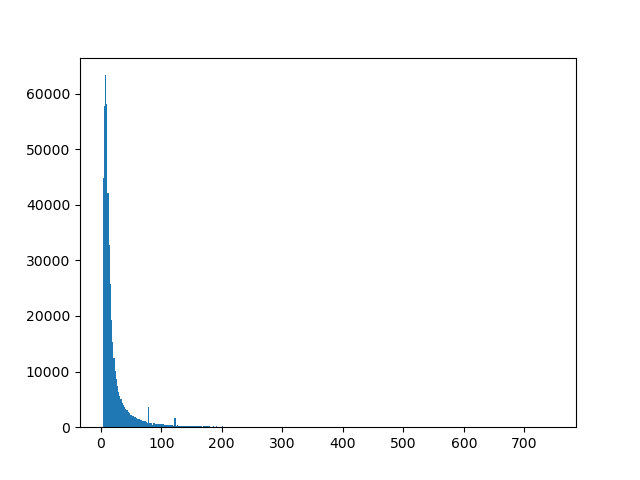

In [56]:
%matplotlib notebook
betweenPulsesTimes = []
for i in dfPulses["timeBetweenPeaks"]:
    betweenPulsesTimes.extend(i)

nBinsFit = int(2*(len(betweenPulsesTimes)**(2/5.0)))
    
histData = plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.show()

In [57]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [58]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [63]:
fittingBoundsAmp = (2000, 180000)
fittingBoundsLam = (1e-9, 1.00)

In [64]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [65]:
distAmp

81257.65746189181

In [66]:
distLambda

0.07516747560211184

<IPython.core.display.Javascript object>


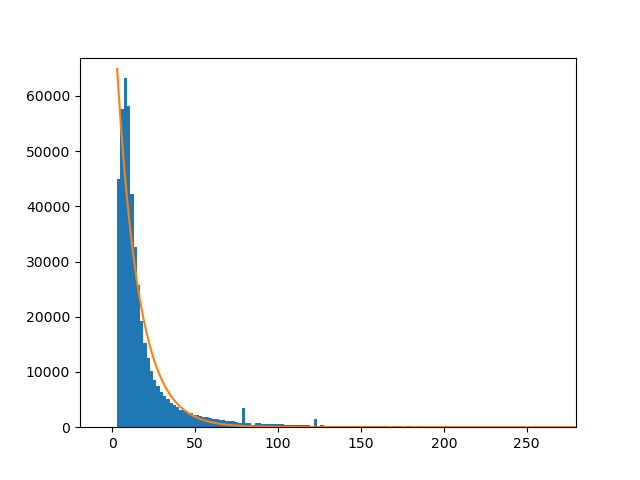

In [67]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()

# Determining pulse waveform of arrivalTimes artifact at sample #590

In [165]:
len(dfPulses)

3836

In [166]:
# regionOfInterest = range(588, 593)
regionOfInterest = range(440, 470)
pulseIndexes = []

#Filtering only "wierd" pulses from the dataset
for i in range(len(dfPulses)):
    for j in dfPulses["arrivalTimes"].iloc[i]:
        if j in regionOfInterest:
            pulseIndexes.append(i)
            break

<IPython.core.display.Javascript object>


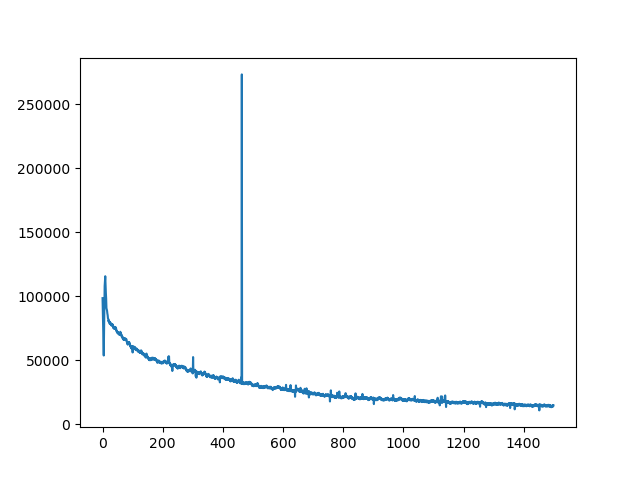

In [147]:
#Summing up "sample by sample" all the pulses contribution

%matplotlib notebook
wierdPulses = dfPulses.iloc[pulseIndexes[:]]
wierdPulses = wierdPulses.sum()
plt.plot(wierdPulses[:PMT_PULSE_LENGTH])
plt.show()

<IPython.core.display.Javascript object>


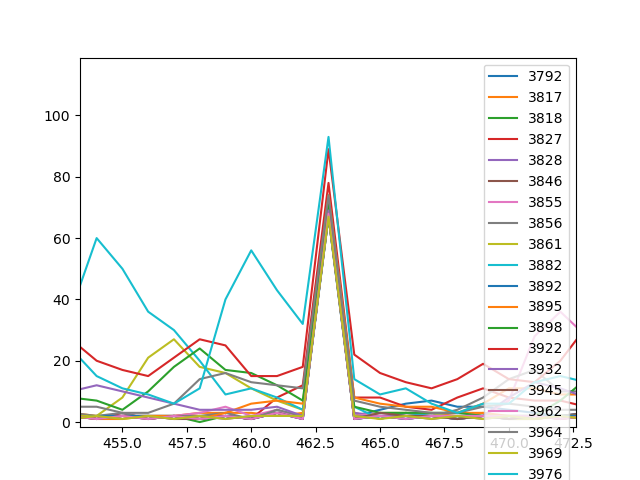

In [100]:
#Examining single pulses

import random

currentPulse = random.randrange(len(pulseIndexes))
pulsesToPlot = 20

%matplotlib notebook
wierdPulses = dfPulses.iloc[pulseIndexes[currentPulse:currentPulse + pulsesToPlot]]

wierdPulses[wierdPulses.columns[:PMT_PULSE_LENGTH]].T.plot()
plt.show()

## Examining single (random) pulses from the original dataset. Looking for abnormality at sample #590

<IPython.core.display.Javascript object>


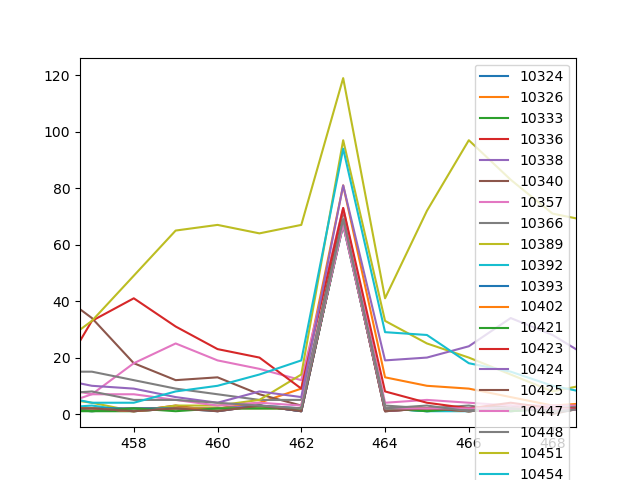

In [101]:
#Comparing with whole dataset (not only wierd puluses)

import random

currentPulse = random.randrange(len(dfPulses))
pulsesToPlot = 20

%matplotlib notebook
dfPulses.iloc[currentPulse:currentPulse + pulsesToPlot][dfPulses.columns[:PMT_PULSE_LENGTH]].T.plot()

plt.show()